In [182]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import torch.linalg as linalg

dataset = torch.tensor([[0.,8.],[1.,8.],[2.,8.],[3.,8.],[4.,8.],
                        [0.,7.],[1.,7.],[2.,7.],[3.,7.],[4.,7.],
                        [0.,6.],[1.,6.],[2.,6.],[3.,6.],[4.,6.],
                        [0.,5.],[1.,5.],[2.,5.],[3.,5.],[4.,5.],
                        [0.,4.],[1.,4.],[2.,4.],[3.,4.],[4.,4.],
                        [0.,3.],[1.,3.],[2.,3.],[3.,3.],[4.,3.],
                        [0.,2.],[1.,2.],[2.,2.],[3.,2.],[4.,2.],
                        [0.,1.],[1.,1.],[2.,1.],[3.,1.],[4.,1.]])

labels = torch.tensor(  [0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,1.,0.,0.,
                         1.,1.,1.,0.,1.,
                         1.,1.,0.,1.,1.,
                         1.,1.,1.,1.,1.,
                         1.,1.,1.,1.,1.])

train_data = []
train_data0 = []
train_data1 = []

for i in range(len(dataset)):
   train_data.append([dataset[i], labels[i]])
   if labels[i] == 0:
      train_data0.append([dataset[i], labels[i]])
   elif labels[i] == 1:
      train_data1.append([dataset[i], labels[i]])

In [183]:
class ModelloF(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size, IS_AFTER = True):
        super(ModelloF, self).__init__()
        self.ort_base = None
        self.IS_AFTER = IS_AFTER

        self.loss = torch.nn.BCEWithLogitsLoss()

        self.W0 = torch.nn.Linear(input_size, hidden_size)
        self.W1 = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.ReLU = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.Adam(self.parameters())
        
    def forwardL1(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2(W1 * R1(W0 * x))) 
        '''
        
        z = self.ReLU(self.W0(x))
        u = self.W1(z)
        v = self.ReLU(u)

        y = self.W2(v)
        
        if self.IS_AFTER:
            return y, v.clone().detach() # Ritorno sa y che le v (che mi servono per la proiezione)
        else:
            return y, u.clone().detach()


    def forwardL2(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2( u))
        '''

        z = self.ReLU(self.W0(x))
        u = self.W1(z)

        if self.IS_AFTER:
            v = self.ReLU(u)
            v_orto = self._Projection(v)
            y = self.W2(v_orto)
        else:
            u_orto = self._Projection(u)
            v = self.ReLU(u_orto)
            y = self.W2(v)
        
        return y

# ----------------------------------------------------------

    def forward(self, x, mode = 'inference'):
        if mode == 'inference':
            with torch.no_grad():
                y, _ = self.forwardL1(x)
            return self.Sigmoid(y)
        elif mode == 'L1':
            return self.forwardL1(x)
        elif mode == 'L2':
            return self.forwardL2(x)
        elif mode == 'inference no sigmoid':
            with torch.no_grad():
                y, _ = self.forwardL1(x)
            return y


    def train(self, dl, mode = 'L1'):
        for x,y in dl:
            self.optimizer.zero_grad()

            if mode == 'L1':
                y_pred, _ = self(x, mode)
            elif mode == 'L2':
                y_pred = self(x, mode)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()
        return e.detach().numpy()
    
    def test(self, dl):
        '''  
        questa funzione testa il modello sul dataset in input usando il modello in modalità L1 (senza la matrice di proiezione)
        ''' 

        with torch.no_grad():    
            for x,y in dl:
                y_pred, _ = self(x, 'L1')
                e = self.loss(y_pred, y.unsqueeze(1))

        return e.detach().numpy()

# ----------------------------------------------------------

    def _Projection(self, u):
        # Project u on them and return it
        return torch.mm(u, self.ort_base)

    def generate_orthogonal_base(self, dl):
        base = None
        with torch.no_grad():
            for x,y in dl:  
                _, v = self(x, 'L1')
                if base is None:
                    base = v
                else:
                    base = torch.cat((base, v), dim = 0)

        # Base is now a tensor (N x hidden_size)

        q, r = torch.linalg.qr(base.T, mode = 'reduced')
        diag = torch.diagonal(r)
        mask = torch.where(diag != 0)
        base = q.T[mask] # Colonne Indipendenti e normalizzate

        self.ort_base = self._orthogonal_base(base)
        # orthogonal projection matrix will be (hidde_size x hidden_size)

    def _orthogonal_base(self, A):
            # Suppose hidden_size == 10
            # A = Nx10
            A = A.T
            # A = 10xN
                
            AAT = torch.matmul(A.T, A)
            # AAT = NxN

            AAT_INV = torch.linalg.solve(AAT, torch.eye(AAT.shape[0])) 
            # AAT_INV = NxN

            P_a = torch.matmul(A, AAT_INV) 
            # P_a = 10xN
            P_a = torch.matmul(P_a, A.T) 
            # P_a = 10x10
            P = torch.eye(P_a.shape[0]) - P_a 
            return P

In [184]:
#INIZIALIZZAZIONE SEED, MODELLO E DATALOADERS

torch.manual_seed(66)
modello = ModelloF(2,1,100, False)
dl0 = torch.utils.data.DataLoader(train_data0, batch_size = 8, shuffle = True)
dl1 = torch.utils.data.DataLoader(train_data1, batch_size = 8, shuffle = True)

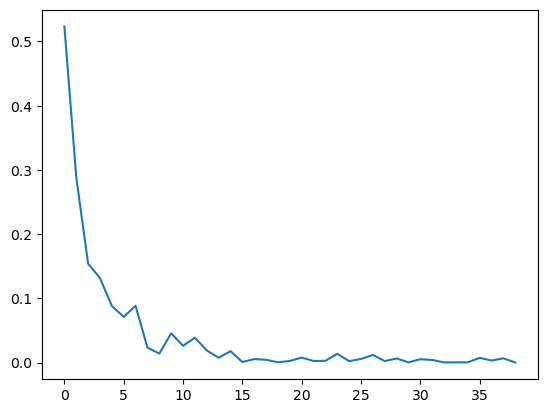

In [185]:
#TRAIN FASE 1
e = 1
err = []
while e > 1e-4:
    e = modello.train(dl1, 'L1') # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err.append(e) 

plt.plot([x for x in range(len(err))], err, label = "Loss")
plt.show()

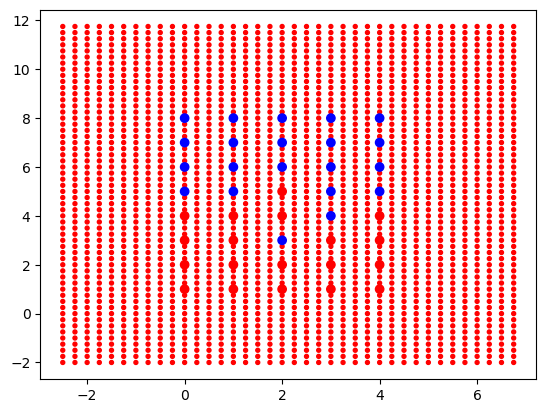

In [186]:
#PLOT FASE 1

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < 0.4 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione

In [187]:
print(modello(torch.tensor([0,0], dtype=torch.float)))

tensor([0.9451])


In [188]:
#TRAIN FASE 2
modello.generate_orthogonal_base(dl1)

err = []
err_L1 = []
err_L2 = []

e_L1 = 1e-4
while e_L1 < .1:
    e = modello.train(dl0, 'L2')
    err.append(e)
    
    e_L1 = modello.test(dl1)
    err_L1.append(e_L1)
    e_L2 = modello.test(dl0)
    err_L2.append(e_L2)

5.864387e-05
0.0001340263
0.00065421336
0.0013546363
0.00012456746
0.01107169
0.0017701313
0.0007017983
0.001493047
0.001139146
0.0015114719
0.0019636995
0.0010532062
0.002409227
0.001799733
0.0023478067
0.014324621
0.0048843194
0.0072532087
0.0066736895
0.024689974
0.00092313724
0.0010120958
0.0056980937
0.0008951723
0.011343495
0.019897062
0.00096409785
0.022782259
0.0010933643
0.0004337282
0.0065418477
0.004035047
0.0006738493
0.002317855
0.010892951
0.0038085312
0.004047802
0.011588461
0.0038317305
0.006933401
0.02065391
0.0036737025
0.0019843758
0.003808897
0.0064252676
0.023599146
0.001235509
0.0022974939
0.0023002985
0.02340428
0.0018530524
0.020781262
0.009879095
0.0023627153
0.010537787
0.0054197214
0.010847866
0.007526793
0.0076495805
0.004764126
0.0029225647
0.020731928
0.011162919
0.009039317
0.0042531476
0.0073057073
0.008185078
0.0040098038
0.0012076936
0.00083259074
0.0112935295
0.0003693611
0.00023675246
0.0049123624
0.0006657255
0.005669451
0.00035452796
0.008373474
0.

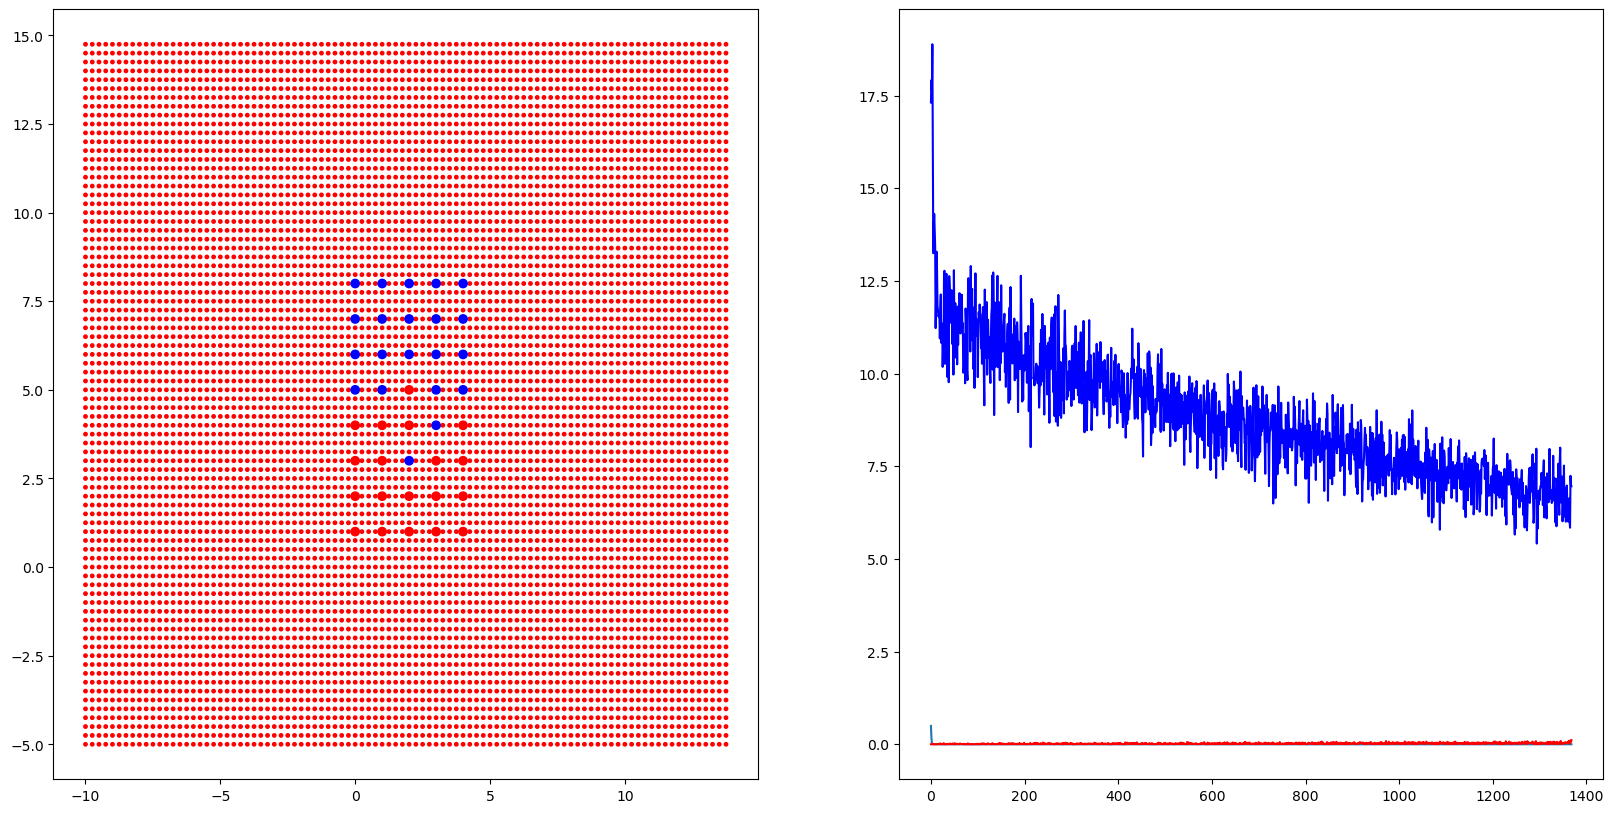

In [189]:
#PLOT FASE 2
# while modello(torch.tensor([2.,5.])).detach().numpy() > 0.45:
#     modello.train(dl0, 'L2')

fig, plot = plt.subplots(1, 2, figsize=(20, 10))
with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10*4,14*4) for y in range(-5*4,15*4)]
    colori = ['blue' if p[2][0] < 0.4 else 'red' if p[2][0] > 0.6 else 'white' for p in points]

    plot[0].scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=6)
    plot[0].scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plot[1].plot([x for x in range(len(err))], err,label='in training')
    plot[1].plot([x for x in range(len(err_L1))], err_L1,label='L1',color='red')
    plot[1].plot([x for x in range(len(err_L2))], err_L2,label='L2',color = 'blue')
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione

In [190]:
ptt = [(0,2),(2,3),(2,5),(4,8)]
for x, y in ptt:
    print(f'({x},{y}) - {modello(torch.tensor([x,y], dtype = torch.float))}')


(0,2) - tensor([0.9178])
(2,3) - tensor([0.9800])
(2,5) - tensor([0.9960])
(4,8) - tensor([0.9998])
